In [10]:
import numpy as np
np.set_printoptions(precision=4)
import torch
import requests
!pip install docx2txt
from enum import Enum
import json

  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=c46d56c12e1dbd7fa4f3d741fd3abd32750722e3f5e3cfc9747af196f536b6e5
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt


**Template**

In [11]:
class DocType(Enum):
    RESUME = 'резюме'
    VACANCY = 'вакансия'

    def template(self):
        if self == self.RESUME:
            return RESUME_JSON_TEMPLATE
        else:
            return VACANCY_JSON_TEMPLATE

In [12]:
VACANCY_JSON_TEMPLATE = """{
    "отдел": {
        "название": ""
    },
    "зарплата": {
        "до": "",
        "с": "",
        "валюта": "",
        "гросс": ""
    },
    "название": "",
    "территория": "",
    "время работы": "",
    "опыт": [{
      "название": ""
    }],
    "условия работы": [{
      "название": ""
    }],
    "описание": "",
    " навыки": [
        {"название":""}
    ]
}"""

In [13]:
RESUME_JSON_TEMPLATE = """{
    "дата рождения": "",
    "пол": "",
    "территория": "",
    "название": "",
    "специализация": [
        {
            "название": "",
        }
    ],
    "зарплата": {
        "сумма": "",
        "валюта": ""
    },
    "уровень образования": "",
    "образование": [
        {
            "год": "",
            "название": "",
            "организация": ""
        }
    ],
    "язык": [
        {
            "название": "",
            "уровень": ""
        }
    ],
    "опыт": [
        {
            "компания": "",
            "начало работы": "",
            "конец работы": "",
            "позиция": "",
            "описание": ""
        }
    ],
    "набор навыков": [
        ""
    ],
    "дополнительная информация": ""
}"""

In [14]:
OPENAI_API_KEY = ...

In [15]:
def generate_json_from_text(text, doc_type: DocType):
    api_endpoint = "https://api.openai.com/v1/chat/completions"

    json_template = doc_type.template()

    sys_prompt = f"Преобразуй текст {doc_type.value} в JSON.\nJSON шаблон: {json_template}"
    prompt = f"{doc_type.value}: {text}"

    headers = {"Authorization": f"Bearer {OPENAI_API_KEY}", "Content-Type": "application/json"}
    data = {
        "model": "gpt-3.5-turbo",
        "messages": [
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": prompt}
        ],
        # "max_tokens": 4096  # Adjust as needed
    }

    response = requests.post(api_endpoint, headers=headers, json=data)

    # Check for a successful response
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        raise Exception(f"Error: {response.status_code}", response.text)

In [16]:
def process_text_1(text):
    text = text.replace('\n', ' ')
    text = text.replace('\xa0', ' ')
    text = text.replace('<ul>', ' ')
    text = text.replace('<li>', ' ')
    text = text.replace('<strong>', ' ')
    text = text.replace('</strong>', ' ')
    text = text.replace('</li>', ' ')
    text = text.replace('</ul>', ' ')
    text = text.replace('<p>', ' ')
    text = text.replace('</p>', ' ')
    text = text.replace('<br />', ' ')
    text = text.replace('<br/>', ' ')
    
    return text

In [17]:
import re


def process_text_2(text):
    text = text.lower()
    text = process_text_1(text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [18]:
def template_text(text, doc_name):
    if doc_name[:7] == 'vacancy':  
        templated_text = generate_json_from_text(text, DocType.VACANCY)
    else:
        templated_text = generate_json_from_text(text, DocType.RESUME)
    return templated_text

In [19]:
def make_fields_dict(templated_text):
    json_dict = json.loads(templated_text)
    fields_dict = {}
    for field in json_dict.keys():
        fields_dict[field] = process_text_2(str(json_dict[field]))
    return fields_dict

**Data loading**

In [20]:
import json
import os

docs = []

path = '/kaggle/input/my-vacancy-resume-dataset'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        with open(os.path.join(dirname, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            docs.append(data)

In [21]:
resume_counts = []
for doc in docs:
    if doc['doc_name'][:7] == 'vacancy':
        for res_id in doc['relevant_files']:
            if res_id[:7] == 'vacancy':
                doc['relevant_files'].remove(res_id) 
                resume_counts.append(len(doc['relevant_files']))

In [22]:
from collections import Counter

distribution = Counter(resume_counts)

print(distribution)
print('Количество резюме: ', sum(resume_counts))
print('Количество вакансий: ', len(resume_counts))

Counter({11: 2, 2: 2, 4: 2, 9: 1, 8: 1, 13: 1, 5: 1, 1: 1, 17: 1, 3: 1})
Количество резюме:  90
Количество вакансий:  13


**Text vectorization**

In [23]:
# embedding for short doc or paragraph (num of tokens < 512)
def get_par_embedding(model, tokenizer, paragraph):
    # paragraph = process_text_2(paragraph)
    paragraph = re.sub(r"[{}\[\]\"']", '', str(paragraph))
     
    encoded_input = tokenizer(
        paragraph, 
        padding=True, 
        truncation=True, 
#         add_special_tokens=False, 
        return_tensors='pt'
    )
    
    # max_segment_length = 512
    # segments = [encoded_input[i:min(i + max_segment_length, len(encoded_input))] 
    #             for i in range(0, len(encoded_input), max_segment_length)]
    
    # avg_model_output = 0
    # for segment in segments:
    #     model_output = model(**encoded_input)
    #     avg_model_output += model_output.last_hidden_state.detach().numpy().mean(axis=1).squeeze()

    ######
    
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(output.last_hidden_state.size())
    sum_embeddings = torch.sum(output.last_hidden_state * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    embeddings = sum_embeddings / sum_mask

    return embeddings.detach().numpy().squeeze()


# mean of pargraphs' embeddings
def get_doc_embedding1(model, tokenizer, doc, **kwargs):
    par_embeddings = []
    for name, par in doc.items():
        if len(par.split()) > 0:
            par_embeddings.append(get_par_embedding(model, tokenizer, par))
    return np.vstack(par_embeddings).mean(axis=0)

In [24]:
def get_par_embedding_gpt(model, tokenizer, paragraph):
    encoded_input = tokenizer.encode(str(paragraph), return_tensors="pt", truncation=True)
    model_output = model(encoded_input)[0]
    return model_output.squeeze().mean(axis=0).detach().numpy()


def get_doc_embedding1_gpt(model, tokenizer, doc, **kwargs):
    par_embeddings = []
    for name, par in doc.items():
        if len(par.split()) > 0:
            par_embeddings.append(get_par_embedding_gpt(model, tokenizer, par))
    return np.vstack(par_embeddings).mean(axis=0)

In [25]:
# embedding for short doc or paragraph (num of tokens < 512)
def get_par_embedding_sentence(model, tokenizer, paragraph):
    embedding = model.encode([paragraph])
    return embedding.squeeze(0)

# mean of pargraphs' embeddings
def get_doc_embedding1_sentence(model, tokenizer, doc, **kwargs):
    par_embeddings = []
    for name, par in doc.items():
        if len(par.split()) > 0:
            par_embeddings.append(get_par_embedding(model, par))
    return np.vstack(par_embeddings).mean(axis=0)

**Оценка качества**

In [27]:
def precision_n(n, relevant_ids_arr, sorted_ids_arr):
    union = 0
    for doc_id in sorted_ids_arr:
        if doc_id in relevant_ids_arr:
            union += 1
    return union / n
    
def average_precision_n(n, docs, model, tokenizer, embedder, field, prior=None, prior_model=None):
    total_score = 0.0
    docs_ids_arr = []
    docs_vecs_arr = []
    
    vacs = [doc for doc in docs if doc['doc_name'][:7] == 'vacancy']
    docs_vacs_arr = []

    for doc in vacs:
        docs_ids_arr += doc['relevant_files']
        
        if prior != 'Random':
            for relevant_resume in doc['relevant_files']:
                for i, item in enumerate(docs):
                    if item['doc_name'] == relevant_resume:
                        docs_vecs_arr.append(embedder(model, tokenizer, docs[i][field])) 
            
    docs_ids_arr = np.array(docs_ids_arr)
    docs_vecs_arr = np.array(docs_vecs_arr)
    
    for doc in vacs:
            
        vac_score = 0.0
        vacancy_vec = embedder(model, tokenizer, doc[field])

        if prior is None or prior == 'Random':
            vacancy_vec = np.array(vacancy_vec)[None, :]
            
        elif prior == 'Linear':
            vacancy_vec = prior_model(torch.tensor(vacancy_vec)).detach().numpy()[None, :]
        
        docs_vacs_arr.append(vacancy_vec)
            

        resumes_ids_arr = doc['relevant_files']

        if prior == 'Random':
            sorted_indices = np.random.choice(len(docs_ids_arr), len(docs_ids_arr))
            
        else:
            scores_arr = cosine_similarity(vacancy_vec, docs_vecs_arr)
            sorted_indices = np.argsort(scores_arr)[0][::-1]
        
        output_arr = docs_ids_arr[sorted_indices[:n]]
        
        print(doc['doc_name'])
        print('True resumes: ', resumes_ids_arr)
        print('\n')
        print('Recommended resumes: ', output_arr)
        print('-' * 50)

        for k in range(1, n + 1):
            if k <= len(output_arr) and output_arr[k - 1] in resumes_ids_arr:
                precision = precision_n(k, resumes_ids_arr, output_arr[:k])
                vac_score += precision
        vac_score /= len(resumes_ids_arr)
        total_score += vac_score
    return docs_vacs_arr, docs_vecs_arr, total_score / len(vacs)

In [29]:
def mmd_cosine(X, Y):
    """
    Вычисляет MMD между двумя выборками X и Y с использованием косинусного ядра.

    Args:
        X (np.ndarray): Первая выборка размером (n_samples_X, n_features).
        Y (np.ndarray): Вторая выборка размером (n_samples_Y, n_features).

    Returns:
        float: Значение MMD.
    """
    # Косинусное ядро для X и Y
    K_XX = cosine_similarity(X, X)
    K_YY = cosine_similarity(Y, Y)
    K_XY = cosine_similarity(X, Y)
    
    # Средние значения ядра
    mmd = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd


In [31]:
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
from functools import partial
from functools import partial
np.random.seed(42)

**Модели для векторизации**

BERT multilingual: bert-base-multilingual-cased обучалась на Википедии на 104 языках.

DeepPavlov RuBERT: rubert-base-cased обучалась на Википедии на русском языке, новостных статьях.

Модели от Sberbank AI:
1.  ruBERT: ruBERT-base, ruBERT-large обучались на русской Википедии, новостях. 
2.  ruRoberta: ruRoberta-large обучалась на русской Википедии, новостях, книгах.
3.  ruGPT: ruGPT-3-small, ruGPT-3-medium, ruGPT-3-large, ruGPT-2-large обучались на русской Википедии, новостях, книгах, английской Википедии, С4.


In [32]:
results = {}
results_vecs = {}

n_arr = [10, 20]

results = {'Bert_multilingual': {'paragraph': {10: {'cls': 0.10465997049707457,
    'mean': 0.12125826941060726},
   20: {'cls': 0.1302908496831157, 'mean': 0.16029798515852192}},
  'text': {10: {'cls': 0.10522663750416389, 'mean': 0.10277543534896474},
   20: {'cls': 0.11620146184797221, 'mean': 0.14035844016241555}}},
 'Bert_Russian': {'paragraph': {10: {'cls': 0.0911225940977072,
    'mean': 0.1218266838741952},
   20: {'cls': 0.1212173654861308, 'mean': 0.1540530510213768}},
  'text': {10: {'cls': 0.0597156760618299, 'mean': 0.10465735789265201},
   20: {'cls': 0.0701140441869295, 'mean': 0.12860571582825292}}},
 'DeepPavlov_RuBERT': {'paragraph': {}, 'text': {}},
 'Random': {10: 0.031136266741470364, 20: 0.046914661607006115},
 'rugpt2large': {'paragraph': {10: 0.11472967287446925,
   20: 0.14146655541630535},
  'text': {10: 0.05642951296231839, 20: 0.08349721287893694}},
 'rugpt3large': {'paragraph': {10: 0.10950117629981883,
   20: 0.13789103821155102},
  'text': {10: 0.12189212978240126, 20: 0.14436740158156675}}}

**Random**

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

In [ ]:
n = 10
max_iter = 3
total_score = 0

for i in range(max_iter):
    total_score += average_precision_n(n, docs, model, tokenizer, get_doc_embedding1, prior='Random', field='fields_dict')[-1]

total_score /= max_iter
results['Random'] = {}
results['Random'][10] = score
total_score

In [ ]:
n = 20
max_iter = 3
total_score = 0

for i in range(max_iter):
    total_score += average_precision_n(n, docs, model, tokenizer, get_doc_embedding1, prior='Random', field='fields_dict')[-1]

total_score /= max_iter
results['Random'][20] = total_score
total_score

**BERT multilingual**

In [185]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

results['Bert_multilingual'] = {}
# results['Bert_multilingual']['paragraph'] = {}
results['Bert_multilingual']['text'] = {}

results_vecs['Bert_multilingual'] = {}
# results_vecs['Bert_multilingual']['paragraph'] = {}
results_vecs['Bert_multilingual']['text'] = {}

# for n in n_arr:
#     print(f'n = {n}')
#     docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_doc_embedding1), field='fields_dict')
#     results['Bert_multilingual']['paragraph'][n] = score
#     results_vecs['Bert_multilingual']['paragraph'][n] = (docs_vacs_arr, docs_vecs_arr)

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, get_par_embedding, field='text')
    results['Bert_multilingual']['text'][n] = score
    results_vecs['Bert_multilingual']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


n = 10
vacancy_devops_engineer.docx
True resumes:  ['Zaremba Siarhei Viktorovich.docx', 'Gadirov Jeyhun.docx', 'Kuchinsky Vladimir.docx', 'Aliyev Emil.docx', 'Mikalayeu Viktar.docx', 'Remniov Alexander.docx', 'Bystrenka Uladzimir.docx', 'K Siarhei Viktorovich.docx', 'Dubovik Dzmitry Andreevich.docx', 'Sergei Urbanovich Vladimirovich.docx', 'Serafat Amin_Good English.docx']


Recommended resumes:  ['Ryzhaya Polina Sergeevna.docx' 'Alekseyev Artyom Alexandrovich.docx'
 'Rudkovskaya Veronika.docx' 'Dubodel Valeria Vladimirovna.docx'
 'Rubailo Roman Nikolaevich.docx' 'Zubritsky Daniil Evgenievich.docx'
 'Krutalevich Egor Vyacheslavovich.docx'
 'Anastasia Dmitrievna Nislovskaya.docx' 'Veraxa Tatiana.docx'
 'Larin Michael.docx']
--------------------------------------------------
vacancy_delphi_programmer.docx
True resumes:  ['Petrovskaya Natalia.docx', 'Gladyrev Danila Mikhailovich.docx', 'Basok Nikolay.docx', 'Eugene Kasnerik.docx', 'Kalinin Nikita.docx', 'Alexander Andreevich Zaichenko.doc

In [186]:
results

{'Bert_multilingual': {'text': {10: 0.09994759200075941,
   20: 0.13231886235947102}}}

In [187]:
docs_vacs_arr, docs_vecs_arr = results_vecs['Bert_multilingual']['text'][10]
print('X and Y: ', mmd_cosine(np.array(docs_vacs_arr).squeeze(1), np.array(docs_vecs_arr)))
print('X and X: ', mmd_cosine(np.array(docs_vacs_arr).squeeze(1)[:6], np.array(docs_vacs_arr).squeeze(1)[6:]))
print('Y and Y: ', mmd_cosine(np.array(docs_vecs_arr)[:45], np.array(docs_vecs_arr)[45:]))

X and Y:  0.04232501983642578
X and X:  0.008367538452148438
Y and Y:  0.003908395767211914


**BERT russian**

In [43]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
model = AutoModel.from_pretrained("Geotrend/bert-base-ru-cased")

Some weights of the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at Geotrend/bert-base-ru-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.

In [44]:
results['Bert_Russian'] = {}
results['Bert_Russian']['paragraph'] = {}
results['Bert_Russian']['text'] = {}

results_vecs['Bert_Russian'] = {}
results_vecs['Bert_Russian']['paragraph'] = {}
results_vecs['Bert_Russian']['text'] = {}

In [46]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_doc_embedding1), field='fields_dict')
    results['Bert_Russian']['paragraph'][n] = score
    results_vecs['Bert_Russian']['paragraph'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
vacancy_devops_engineer.docx
True resumes:  ['Zaremba Siarhei Viktorovich.docx', 'Gadirov Jeyhun.docx', 'Kuchinsky Vladimir.docx', 'Aliyev Emil.docx', 'Mikalayeu Viktar.docx', 'Remniov Alexander.docx', 'Bystrenka Uladzimir.docx', 'K Siarhei Viktorovich.docx', 'Dubovik Dzmitry Andreevich.docx', 'Sergei Urbanovich Vladimirovich.docx', 'Serafat Amin_Good English.docx']


Recommended resumes:  ['Ryzhaya Polina Sergeevna.docx' 'Alekseyev Artyom Alexandrovich.docx'
 'Rudkovskaya Veronika.docx' 'Dubodel Valeria Vladimirovna.docx'
 'Rubailo Roman Nikolaevich.docx' 'Krutalevich Egor Vyacheslavovich.docx'
 'Anastasia Dmitrievna Nislovskaya.docx' 'Veraxa Tatiana.docx'
 'Alexander Andreevich Zaichenko.docx' 'Larin Michael.docx']
--------------------------------------------------
vacancy_delphi_programmer.docx
True resumes:  ['Petrovskaya Natalia.docx', 'Gladyrev Danila Mikhailovich.docx', 'Basok Nikolay.docx', 'Eugene Kasnerik.docx', 'Kalinin Nikita.docx', 'Alexander Andreevich Zaichenko.do

KeyboardInterrupt: 

In [47]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, get_par_embedding, field='text')
    results['Bert_Russian']['text'][n] = score
    results_vecs['Bert_Russian']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
vacancy_devops_engineer.docx
True resumes:  ['Zaremba Siarhei Viktorovich.docx', 'Gadirov Jeyhun.docx', 'Kuchinsky Vladimir.docx', 'Aliyev Emil.docx', 'Mikalayeu Viktar.docx', 'Remniov Alexander.docx', 'Bystrenka Uladzimir.docx', 'K Siarhei Viktorovich.docx', 'Dubovik Dzmitry Andreevich.docx', 'Sergei Urbanovich Vladimirovich.docx', 'Serafat Amin_Good English.docx']


Recommended resumes:  ['Ryzhaya Polina Sergeevna.docx' 'Alekseyev Artyom Alexandrovich.docx'
 'Rudkovskaya Veronika.docx' 'Dubodel Valeria Vladimirovna.docx'
 'Rubailo Roman Nikolaevich.docx' 'Krutalevich Egor Vyacheslavovich.docx'
 'Anastasia Dmitrievna Nislovskaya.docx' 'Veraxa Tatiana.docx'
 'Alexander Andreevich Zaichenko.docx' 'Larin Michael.docx']
--------------------------------------------------
vacancy_delphi_programmer.docx
True resumes:  ['Petrovskaya Natalia.docx', 'Gladyrev Danila Mikhailovich.docx', 'Basok Nikolay.docx', 'Eugene Kasnerik.docx', 'Kalinin Nikita.docx', 'Alexander Andreevich Zaichenko.do

In [48]:
results

{'Bert_multilingual': {'paragraph': {},
  'text': {10: 0.10277543534896474, 20: 0.14035844016241555}},
 'Bert_Russian': {'paragraph': {},
  'text': {10: 0.10465735789265201, 20: 0.12860571582825292}}}

In [49]:
docs_vacs_arr, docs_vecs_arr = results_vecs['Bert_Russian']['text'][10]
print('X and Y: ', mmd_cosine(np.array(docs_vacs_arr).squeeze(1), np.array(docs_vecs_arr)))
print('X and X: ', mmd_cosine(np.array(docs_vacs_arr).squeeze(1)[:6], np.array(docs_vacs_arr).squeeze(1)[6:]))
print('Y and Y: ', mmd_cosine(np.array(docs_vecs_arr)[:45], np.array(docs_vecs_arr)[45:]))

X and Y:  0.046160221099853516
X and X:  0.014859199523925781
Y and Y:  0.004398345947265625


**DeepPavlov RuBERT**

In [ ]:
from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
results['DeepPavlov_RuBERT'] = {}
results['DeepPavlov_RuBERT']['paragraph'] = {}
results['DeepPavlov_RuBERT']['text'] = {}

results_vecs['DeepPavlov_RuBERT'] = {}
results_vecs['DeepPavlov_RuBERT']['paragraph'] = {}
results_vecs['DeepPavlov_RuBERT']['text'] = {}

In [ ]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_doc_embedding1), field='fields_dict')
    results['DeepPavlov_RuBERT']['paragraph'][n] = score
    results_vecs['DeepPavlov_RuBERT']['paragraph'][n] = (docs_vacs_arr, docs_vecs_arr)

In [ ]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_par_embedding), field='text')
    results['DeepPavlov_RuBERT']['text'][n] = score
    results_vecs['DeepPavlov_RuBERT']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

**Sberbank AI ruBERT**

In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = 'cointegrated/rubert-base-cased-nli-threeway'
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

In [ ]:
n = 10
average_precision_n(n, docs, model, tokenizer, get_doc_embedding1)

**Sberbank AI RuGPT2Large**

In [51]:
np.random.seed(42)
torch.manual_seed(42)

In [52]:
def get_par_embedding_gpt(model, tokenizer, paragraph):
    encoded_input = tokenizer.encode(str(paragraph), return_tensors="pt", truncation=True)
    model_output = model(encoded_input)[0]
    return model_output.squeeze().mean(axis=0).detach().numpy()


def get_doc_embedding1_gpt(model, tokenizer, doc, **kwargs):
    par_embeddings = []
    for name, par in doc.items():
        if len(par.split()) > 0:
            par_embeddings.append(get_par_embedding_gpt(model, tokenizer, par))
    return np.vstack(par_embeddings).mean(axis=0)

def load_tokenizer_and_model(model_name_or_path):
    return GPT2Tokenizer.from_pretrained(model_name_or_path), GPT2LMHeadModel.from_pretrained(model_name_or_path)

In [53]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer, model = load_tokenizer_and_model("sberbank-ai/rugpt2large")

In [ ]:
n_arr = [10, 20]

In [54]:
results['rugpt2large'] = {}
results['rugpt2large']['paragraph'] = {}
results['rugpt2large']['text'] = {}

results_vecs['rugpt2large'] = {}
results_vecs['rugpt2large']['paragraph'] = {}
results_vecs['rugpt2large']['text'] = {}

In [55]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_par_embedding_gpt), field='text')
    results['rugpt2large']['text'][n] = score
    results_vecs['rugpt2large']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
vacancy_devops_engineer.docx
True resumes:  ['Zaremba Siarhei Viktorovich.docx', 'Gadirov Jeyhun.docx', 'Kuchinsky Vladimir.docx', 'Aliyev Emil.docx', 'Mikalayeu Viktar.docx', 'Remniov Alexander.docx', 'Bystrenka Uladzimir.docx', 'K Siarhei Viktorovich.docx', 'Dubovik Dzmitry Andreevich.docx', 'Sergei Urbanovich Vladimirovich.docx', 'Serafat Amin_Good English.docx']


Recommended resumes:  ['Mazurov Nikolay Viktorovich.docx' 'Dubodel Valeria Vladimirovna.docx'
 'Ryzhaya Polina Sergeevna.docx' 'Larin Michael.docx'
 'Solovey Sergey.docx' 'Alekseyev Artyom Alexandrovich.docx'
 'Polovinko Andrey.docx' 'Bodrov Sergey Alexandrovich.docx'
 'Eugene Kasnerik.docx' 'Kulbako Yevgeny Petrovich.docx']
--------------------------------------------------
vacancy_delphi_programmer.docx
True resumes:  ['Petrovskaya Natalia.docx', 'Gladyrev Danila Mikhailovich.docx', 'Basok Nikolay.docx', 'Eugene Kasnerik.docx', 'Kalinin Nikita.docx', 'Alexander Andreevich Zaichenko.docx', 'Dmitry Rudakovsky.docx'

In [57]:
docs_vacs_arr, docs_vecs_arr = results_vecs['rugpt2large']['text'][10]
print('X and Y: ', mmd_cosine(np.array(docs_vacs_arr).squeeze(1), np.array(docs_vecs_arr)))
print('X and X: ', mmd_cosine(np.array(docs_vacs_arr).squeeze(1)[:6], np.array(docs_vacs_arr).squeeze(1)[6:]))
print('Y and Y: ', mmd_cosine(np.array(docs_vecs_arr)[:45], np.array(docs_vecs_arr)[45:]))

X and Y:  0.07060873508453369
X and X:  0.0035790205001831055
Y and Y:  0.0017381906509399414


**Sberbank AI RuGPT3Large**

In [ ]:
tokenizer, model = load_tokenizer_and_model("sberbank-ai/rugpt3large_based_on_gpt2")

In [ ]:
n_arr = [10, 20]

results['rugpt3large'] = {}
results['rugpt3large']['paragraph'] = {}
results['rugpt3large']['text'] = {}

results_vecs['rugpt3large'] = {}
results_vecs['rugpt3large']['paragraph'] = {}
results_vecs['rugpt3large']['text'] = {}

In [ ]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_doc_embedding1_gpt), field='fields_dict')
    results['rugpt3large']['paragraph'][n] = score
    results_vecs['rugpt3large']['paragraph'][n] = (docs_vacs_arr, docs_vecs_arr)

In [ ]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, partial(get_par_embedding_gpt), field='text')
    results['rugpt3large']['text'][n] = score
    results_vecs['rugpt3large']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

**SentenceTransfotmer**

In [88]:
# embedding for short doc or paragraph (num of tokens < 512)
def get_par_embedding_sentence(model, tokenizer, paragraph):
    embedding = model.encode([paragraph])
    return embedding.squeeze(0)

# mean of pargraphs' embeddings
def get_doc_embedding1_sentence(model, tokenizer, doc, **kwargs):
    par_embeddings = []
    for name, par in doc.items():
        if len(par.split()) > 0:
            par_embeddings.append(get_par_embedding(model, par))
    return np.vstack(par_embeddings).mean(axis=0)

**paraphrase-MiniLM-L6-v2**

In [1]:
pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=64d067da580343089a1f8e79af5e6304c9fd4f1050f4b51f03856d3c2d061f9f
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [ ]:
results['paraphrase-MiniLM-L6-v2'] = {}
results['paraphrase-MiniLM-L6-v2']['paragraph'] = {}
results['paraphrase-MiniLM-L6-v2']['text'] = {}

results_vecs['paraphrase-MiniLM-L6-v2'] = {}
results_vecs['paraphrase-MiniLM-L6-v2']['paragraph'] = {}
results_vecs['paraphrase-MiniLM-L6-v2']['text'] = {}

In [ ]:
for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model, tokenizer, get_par_embedding_sentence, field='text')
    results['paraphrase-MiniLM-L6-v2']['text'][n] = score
    results_vecs['paraphrase-MiniLM-L6-v2']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

{'Bert_multilingual': {'paragraph': {10: 0.12125826941060726,
   20: 0.16029798515852192},
  'text': {10: 0.10277543534896474, 20: 0.14035844016241555}},
 'Bert_Russian': {'paragraph': {10: 0.1218266838741952,
   20: 0.1540530510213768},
  'text': {10: 0.10465735789265201, 20: 0.12860571582825292}},
 'DeepPavlov_RuBERT': {'paragraph': {10: 0.06558314737047768,
   20: 0.10312807264313574},
  'text': {10: 0.07319346185767754, 20: 0.10142473354887666}},
 'paraphrase-MiniLM-L6-v2': {'paragraph': {10: 0.2535981772124306,
   20: 0.29546953459020014},
  'text': {10: 0.3382183565554607, 20: 0.3999563914493064}}}

**Синтетические данные**

In [2]:
import os
import json
from sklearn.model_selection import train_test_split

vacancy_path = '/kaggle/input/vacancies-resumes-23-11-24/vacancies_23_11_24/vacancies_23_11_24'
resume_path = '/kaggle/input/resumes-23-11-24'


vacancies_arr, resumes_arr = [], []

# Соответсвующие друг другу вакансии и резюме с одинаковым названием

for resume in os.listdir(resume_path):
    if resume.endswith(".json"):
        file_path = os.path.join(resume_path, resume)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                data = json.load(file)
                resumes_arr.append(data)
            except json.JSONDecodeError:
                print(f"Ошибка чтения JSON в файле {filename}")

        file_path = os.path.join(vacancy_path, resume)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                data = json.load(file)
                vacancies_arr.append(data)
            except json.JSONDecodeError:
                print(f"Ошибка чтения JSON в файле {filename}")

In [3]:
VACANCY_JSON_TEMPLATE_OLD = """{
    "id": "",
    "department": {
        "id": "",
        "name": ""
    },
    "salary": {
        "to": "",
        "from": "",
        "currency": "",
        "gross": ""
    },
    "name": "",
    "area": {
        "id": "",
        "name": ""
    },
    "working_days": [
        {
            "id": "",
            "name": ""
        }
    ],
    "working_time_intervals": [
        {
            "id": "",
            "name": ""
        }
    ],
    "working_time_modes": [
        {
            "id": "",
            "name": ""
        }
    ],
    "experience": {
      "id": "",
      "name": ""
    },
    "employment": {
      "id": "",
      "name": ""
    },
    "description": "",
    "key_skills": [
        {"name":""}
    ]
}"""

In [4]:
VACANCY_JSON_TEMPLATE_NEW = """{
    "отдел": {
        "название": ""
    },
    "зарплата": {
        "до": "",
        "с": "",
        "валюта": "",
        "гросс": ""
    },
    "название": "",
    "территория": "",
    "время работы": "",
    "опыт": [{
      "название": ""
    }],
    "условия работы": [{
      "название": ""
    }],
    "описание": "",
    "навыки": [
        {"название":""}
    ]
}"""

In [5]:
RESUME_JSON_TEMPLATE_OLD = """{
    "birth_date": "",
    "gender": "",
    "area": "",
    "title": "",
    "specialization": [
        {
            "name": "",
            "profarea_name": ""
        }
    ],
    "salary": {
        "amount": "",
        "currency": ""
    },
    "education_level": "",
    "education": [
        {
            "year": "",
            "name": "",
            "organization": ""
        }
    ],
    "language": [
        {
            "name": "",
            "level": ""
        }
    ],
    "experience": [
        {
            "company": "",
            "start": "",
            "end": "",
            "position": "",
            "description": ""
        }
    ],
    "skill_set": [
        ""
    ],
    "additional_info": ""
}"""

In [6]:
RESUME_JSON_NEW = """{
    "дата рождения": "",
    "пол": "",
    "территория": "",
    "название": "",
    "специализация": [
        {
            "название": "",
        }
    ],
    "зарплата": {
        "сумма": "",
        "валюта": ""
    },
    "уровень образования": "",
    "образование": [
        {
            "год": "",
            "название": "",
            "организация": ""
        }
    ],
    "язык": [
        {
            "название": "",
            "уровень": ""
        }
    ],
    "опыт": [
        {
            "компания": "",
            "начало работы": "",
            "конец работы": "",
            "позиция": "",
            "описание": ""
        }
    ],
    "набор навыков": [
        ""
    ],
    "дополнительная информация": ""
}"""

In [7]:
def transform_vacancy(old_json):
    """
    Преобразует JSON из формата OLD в формат NEW.
    """
    new_json = {
        "отдел": old_json.get("department", {}).get("name", "") if old_json.get("department") else "",
        "зарплата": {
            "до": old_json.get("salary", {}).get("to", "") if old_json.get("salary") else "",
            "с": old_json.get("salary", {}).get("from", "") if old_json.get("salary") else "",
            "валюта": old_json.get("salary", {}).get("currency", "") if old_json.get("salary") else "",
            "гросс": old_json.get("salary", {}).get("gross", "") if old_json.get("salary") else ""
        },
        "название": old_json.get("name", ""),
        "территория": old_json.get("area", {}).get("name", "") if old_json.get("area") else "",
        "время работы": ", ".join([
            interval.get("name", "") for interval in old_json.get("working_time_intervals", []) if interval
        ]),
        "опыт": [old_json.get("experience", {}).get("name", "") if old_json.get("experience") else ""],
        "условия работы": [old_json.get("employment", {}).get("name", "") if old_json.get("employment") else ""
        ],
        "описание": old_json.get("description", ""),
        "навыки": [skill.get("name", "") for skill in old_json.get("key_skills", []) if skill]
    }
    
    # Преобразование словаря в JSON-строку
    new_json_str = json.dumps(new_json, ensure_ascii=False, indent=4)
    
    return make_fields_dict(new_json_str)


def transform_resume(old_json):
    """
    Преобразует JSON из формата OLD в формат NEW.
    """
    # Преобразование данных в словарь
    new_json = {
        "дата рождения": old_json.get("birth_date", ""),
        "пол": old_json.get("gender", ""),
        "территория": old_json.get("area", ""),
        "название": old_json.get("title", ""),
        "специализация": [spec.get("name", "") for spec in old_json.get("specialization", []) if spec],
        "зарплата": {
            "сумма": old_json.get("salary", {}).get("amount", ""),
            "валюта": old_json.get("salary", {}).get("currency", "")
        },
        "уровень образования": old_json.get("education_level", ""),
        "образование": [
            {
                "год": edu.get("year", ""),
                "название": edu.get("name", ""),
                "организация": edu.get("organization", "")
            }
            for edu in old_json.get("education", [])
            if edu
        ],
        "язык": [
            {
                "название": lang.get("name", ""),
                "уровень": lang.get("level", "")
            }
            for lang in old_json.get("language", [])
            if lang
        ],
        "опыт": [
            {
                "компания": exp.get("company", ""),
                "начало работы": exp.get("start", ""),
                "конец работы": exp.get("end", ""),
                "позиция": exp.get("position", ""),
                "описание": exp.get("description", "")
            }
            for exp in old_json.get("experience", [])
            if exp
        ],
        "набор навыков": old_json.get("skill_set", []),
        "дополнительная информация": old_json.get("additional_info", "")
    }

    new_json_str = json.dumps(new_json, ensure_ascii=False, indent=4)
    
    return make_fields_dict(new_json_str)

In [33]:
import re

vacancies_arr = [re.sub(r"[{}\[\]\"']", '', str(transform_vacancy(vacancy))) for vacancy in vacancies_arr]
resumes_arr = [re.sub(r"[{}\[\]\"'\\]", '', str(transform_resume(resume))) for resume in resumes_arr]

In [38]:
data = [{'job': vacancies_arr[i], 'resume': resumes_arr[i]} for i in range(len(vacancies_arr))]

In [40]:
data[300]

{'job': 'отдел: , зарплата: до: 200000, с: 150000, валюта: RUR, гросс: False, название: Бухгалтер / Заместитель главного бухгалтера, территория: Москва, время работы: , опыт: От 3 до 6 лет, условия работы: Полная занятость, описание: Крупная страховая компания с европейским индивидуальным сервисом в поисках Бухгалтера / Заместителя главного бухгалтера . Обязанности: - Формирование статистической отчетности (в Банк России); - Участие в формировании бухгалтерской (финансовой) отчетности (БФО и ОПН); - Формирование отчетности в Росстат; - Составление аналитических таблиц по деятельности компании; - Работа в КИАС (формирование оборотно – сальдовых ведомостей, журналов договоров и убытков, привязка платежей премий от страхователей и т.д) ; - Работа с архивом; - Ответы на запросы государственных органов, арбитражных (конкурсных) управляющих, судебных приставов и др. Требования: - Опыт работы в страховых компаниях от года; - Уверенный пользователь ПК, свободное владение офисными программами (

In [106]:
def average_precision_n(n, docs, model, tokenizer, embedder, field, prior=None, prior_model=None):
    total_score = 0.0
    
    (vacs_vecs, resumes_vecs) = docs
    
    for i, vac in enumerate(vacs_vecs):
        vacancy_vec = vacs_vecs[i][None, :]
        if prior_model:
            vacancy_vec = prior_model(torch.tensor(vacancy_vec, dtype=torch.float)).detach().numpy()
        scores_arr = cosine_similarity(vacancy_vec, resumes_vecs)
        sorted_indices = np.argsort(scores_arr)[0][::-1]
        k = np.where(sorted_indices == i)[0]
        if k < n:
            total_score += 1 / (k + 1)
    return vacs_vecs, resumes_vecs, total_score / len(vacs_vecs)

**Линейный слой**

In [127]:
import matplotlib.pyplot as plt

device = torch.device('cpu')

class MyPrior(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(MyPrior, self).__init__()
        self.l1 = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.l1.weight = torch.nn.Parameter(torch.eye(hidden_dim, hidden_dim))

    def forward(self, x):
        x = self.l1(x)
        return x

def calculate_loss(Y_pred, Y):
    return torch.mean(torch.sum((Y_pred - Y)**2, dim=1))
    # loss = torch.nn.CosineEmbeddingLoss()
    # return loss(Y_pred, Y, torch.ones(Y.shape[0]))

@torch.no_grad()
def calculate_score(Y_pred, Y):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
    return cos(Y_pred, Y).mean()


def train_epoch(
    network,
    X,
    Y,
    criterion,
    optimizer,
    num_epoch
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train() 
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad() 
    Y_pred = network(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()

    Y_pred = network(X)
    loss = criterion(Y_pred, Y)
    accur = calculate_score(Y_pred, Y).item()
    
    # print(
    #     f'Train set Epoch {num_epoch}: Loss: {loss:.4f}, Accuracy: {accur:.4f}'
    # )
    return loss.item(), accur


@torch.no_grad()
def val_epoch(
    network,
    X,
    Y,
    criterion,
    num_epoch
):
    """calculate loss and accuracy on validation data"""
    
    network.eval()  # switch network submodules to test mode
    with torch.no_grad():
        X, Y = X.to(device), Y.to(device)
        Y_pred = network(X)
        val_loss = criterion(Y_pred, Y).item()
        val_accur = calculate_score(Y_pred, Y).item()

    # print(
    #     f'Test set Epoch {num_epoch}: Loss: {val_loss:.4f}, Accuracy: {val_accur:.4f}'
    # )
    # print('-' * 30)
    return val_loss, val_accur

def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    X_train,
    Y_train,
    X_test,
    Y_test
):
    """full cycle of neural network training"""
    train_loss_arr = []
    train_accur_arr = []
    val_loss_arr = []
    val_accur_arr = []
    
    # val_loss, val_accur = val_epoch(network, X_test, Y_test, criterion, 0)
    # val_loss_arr.append(val_loss)
    # val_accur_arr.append(val_accur)
    
    # train_loss_arr.append(val_loss)
    # train_accur_arr.append(val_accur)
    
    for epoch in range(1, n_epochs + 1):
        train_loss, train_accur = train_epoch(network, X_train, Y_train, criterion, optimizer, epoch)
        train_loss_arr.append(train_loss)
        train_accur_arr.append(train_accur)

        if X_test is not None:
            val_loss, val_accur = val_epoch(network, X_test, Y_test, criterion, epoch)
            val_loss_arr.append(val_loss)
            val_accur_arr.append(val_accur)
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].plot(np.arange(len(train_loss_arr)), train_loss_arr, label='train')
    if X_test is not None:
        ax[0].plot(np.arange(len(val_loss_arr)), val_loss_arr, label='test')
    ax[0].set_title('Loss')
    ax[0].grid(True)
    ax[0].legend()
    
    ax[1].plot(np.arange(len(train_accur_arr)), train_accur_arr, label='train')
    if X_test is not None:
        ax[1].plot(np.arange(len(val_accur_arr)), val_accur_arr, label='test')
    ax[1].set_title('Score')
    ax[1].grid(True)
    ax[1].legend()
    
    plt.suptitle('Linear prior')
    plt.show()

**paraphrase-MiniLM-L6-v2**

In [114]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
tokenizer = None

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [116]:
test_size = 200

docs_vacs_arr_train = np.array([get_par_embedding_sentence(model, tokenizer, doc) for doc in vacancies_arr[test_size:]])
docs_resumes_arr_train = np.array([get_par_embedding_sentence(model, tokenizer, doc) for doc in resumes_arr[test_size:]])

docs_vacs_arr_test = np.array([get_par_embedding_sentence(model, tokenizer, doc) for doc in vacancies_arr[:test_size]])
docs_resumes_arr_test = np.array([get_par_embedding_sentence(model, tokenizer, doc) for doc in resumes_arr[:test_size]])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [123]:
results['paraphrase-MiniLM-L6-v2'] = {}
results_vecs['paraphrase-MiniLM-L6-v2'] = {}
results['paraphrase-MiniLM-L6-v2']['text'] = {}
results_vecs['paraphrase-MiniLM-L6-v2']['text'] = {}

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, (docs_vacs_arr_test, docs_resumes_arr_test), model, tokenizer, get_par_embedding_sentence, field='text')
    results['paraphrase-MiniLM-L6-v2']['text'][n] = score
    results_vecs['paraphrase-MiniLM-L6-v2']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
n = 20


In [125]:
idx = len(docs_resumes_arr_test) // 2
print('X and Y: ', mmd_cosine(docs_vacs_arr_test[:idx], docs_resumes_arr_test[:idx]))
print('X and X: ', mmd_cosine(docs_vacs_arr_test[:idx], docs_vacs_arr_test[idx:]))
print('Y and Y: ', mmd_cosine(docs_resumes_arr_test[:idx], docs_resumes_arr_test[idx:]))

X and Y:  0.11838018894195557
X and X:  0.0020208358764648438
Y and Y:  0.0025146007537841797


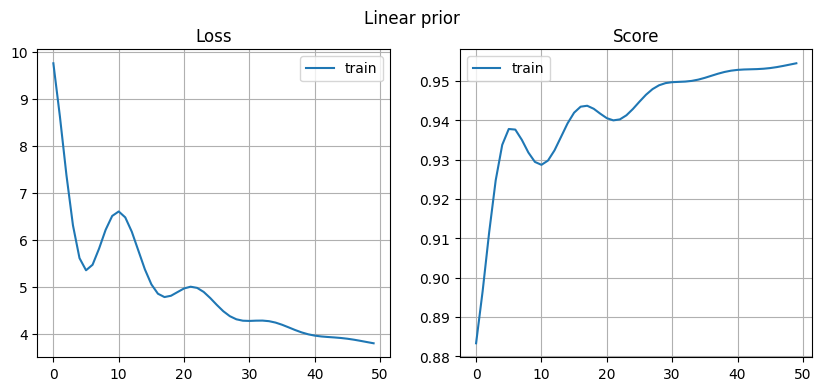

In [132]:
prior = MyPrior(docs_vacs_arr_train.shape[1])
optimizer = torch.optim.SGD(prior.parameters(), lr=0.001, momentum=0.9)

train_val(
    network=prior, 
    n_epochs=50,
    criterion=calculate_loss,
    optimizer=optimizer,
    X_train=torch.tensor(docs_vacs_arr_train),
    Y_train=torch.tensor(docs_resumes_arr_train),
    X_test=None,
    Y_test=None
)

In [133]:
idx = len(docs_resumes_arr_test) // 2
docs_vacs_arr_test_new = prior(torch.tensor(docs_vacs_arr_test)).detach().numpy()
print('X and Y: ', mmd_cosine(docs_vacs_arr_test_new, docs_resumes_arr_test))
print('X and X: ', mmd_cosine(docs_vacs_arr_test_new[:idx], docs_vacs_arr_test_new[idx:]))
print('Y and Y: ', mmd_cosine(docs_resumes_arr_test[:idx], docs_resumes_arr_test[idx:]))

X and Y:  0.000876307487487793
X and X:  0.0017627477645874023
Y and Y:  0.0025146007537841797


In [135]:
results['paraphrase-MiniLM-L6-v2_prior'] = {}
results_vecs['paraphrase-MiniLM-L6-v2_prior'] = {}
results['paraphrase-MiniLM-L6-v2_prior']['text'] = {}
results_vecs['paraphrase-MiniLM-L6-v2_prior']['text'] = {}

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, (docs_vacs_arr_test, docs_resumes_arr_test), model, tokenizer, get_par_embedding_sentence, field='text', prior='Linear', prior_model=prior)
    results['paraphrase-MiniLM-L6-v2_prior']['text'][n] = score
    results_vecs['paraphrase-MiniLM-L6-v2_prior']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
n = 20


In [136]:
results

{'text-embedding-ada-002': {'text': {10: array([0.9029]),
   20: array([0.9029])}},
 'paraphrase-MiniLM-L6-v2': {'text': {10: array([0.2437]),
   20: array([0.2472])}},
 'text-embedding-ada-002_prior': {'text': {10: array([0.9499]),
   20: array([0.9503])}},
 'paraphrase-MiniLM-L6-v2_prior': {'text': {10: array([0.298]),
   20: array([0.3026])}}}

**text_embedding-ada**

In [52]:
!pip install openai

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 9.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 23.4 MB/s eta 0:00:00


In [86]:
import os
from openai import OpenAI
from typing_extensions import Iterator


model="text-embedding-ada-002"
tokenizer=None

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
client = OpenAI()


# get_doc_embedding1(model, tokenizer, doc, pooling='cls', **kwargs)
def get_embedding_openai(model="text-embedding-ada-002", tokenizer=None, doc='abc',  pooling='cls', **kwargs):
   doc = process_text_2(str(doc))
   return client.embeddings.create(input = [doc], model=model).data[0].embedding

In [87]:
test_size = 200

docs_vacs_arr_train = np.array([get_embedding_openai(model, tokenizer, doc) for doc in vacancies_arr[test_size:]])
docs_resumes_arr_train = np.array([get_embedding_openai(model, tokenizer, doc) for doc in resumes_arr[test_size:]])

docs_vacs_arr_test = np.array([get_embedding_openai(model, tokenizer, doc) for doc in vacancies_arr[:test_size]])
docs_resumes_arr_test = np.array([get_embedding_openai(model, tokenizer, doc) for doc in resumes_arr[:test_size]])

In [88]:
idx = len(docs_resumes_arr_test) // 2
print('X and Y: ', mmd_cosine(docs_vacs_arr_test[:idx], docs_resumes_arr_test[:idx]))
print('X and X: ', mmd_cosine(docs_vacs_arr_test[:idx], docs_vacs_arr_test[idx:]))
print('Y and Y: ', mmd_cosine(docs_resumes_arr_test[:idx], docs_resumes_arr_test[idx:]))

X and Y:  0.08776923723569707
X and X:  0.0027005562380970627
Y and Y:  0.0022899798826008233


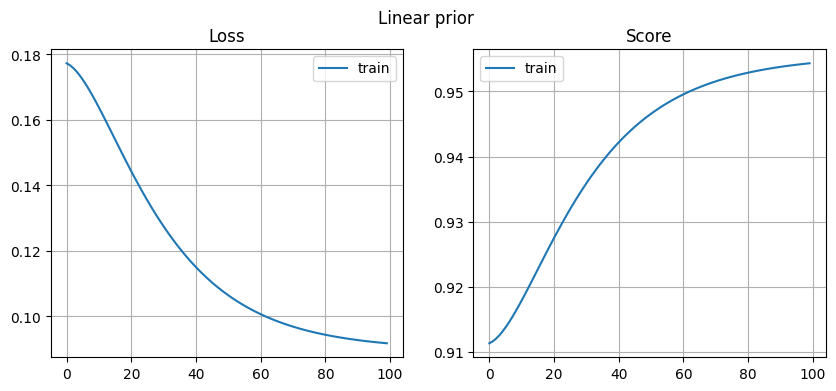

In [111]:
prior = MyPrior(docs_vacs_arr_train.shape[1])
optimizer = torch.optim.SGD(prior.parameters(), lr=0.001, momentum=0.9)

train_val(
    network=prior, 
    n_epochs=100,
    criterion=calculate_loss,
    optimizer=optimizer,
    X_train=torch.tensor(docs_vacs_arr_train, dtype=torch.float),
    Y_train=torch.tensor(docs_resumes_arr_train, dtype=torch.float),
    X_test=None,
    Y_test=None
)

In [94]:
docs_vacs_arr_test_new = prior(torch.tensor(docs_vacs_arr_test, dtype=torch.float)).detach().numpy()
print('X and Y: ', mmd_cosine(docs_vacs_arr_test_new, docs_resumes_arr_test))
print('X and X: ', mmd_cosine(docs_vacs_arr_test[:idx], docs_vacs_arr_test[idx:]))
print('Y and Y: ', mmd_cosine(docs_resumes_arr_test[:idx], docs_resumes_arr_test[idx:]))

X and Y:  0.0027329340834454374
X and X:  0.0027005562380970627
Y and Y:  0.0022899798826008233


In [81]:
results[model] = {}
results[model]['text'] = {}

results_vecs[model] = {}
results_vecs[model]['text'] = {}

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, (vacancies_arr[:test_size], resumes_arr[:test_size]), model, tokenizer, get_embedding_openai, field='text')
    results[model]['text'][n] = score
    results_vecs[model]['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
n = 20


In [112]:
results["text-embedding-ada-002_prior"] = {}
results["text-embedding-ada-002_prior"]['text'] = {}

results_vecs["text-embedding-ada-002_prior"] = {}
results_vecs["text-embedding-ada-002_prior"]['text'] = {}

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, (docs_vacs_arr_test, docs_resumes_arr_test), model, tokenizer, get_embedding_openai, field='text', prior='Linear', prior_model=prior)
    results["text-embedding-ada-002_prior"]['text'][n] = score
    results_vecs["text-embedding-ada-002_prior"]['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
n = 20


In [113]:
results

{'text-embedding-ada-002': {'text': {10: array([0.9029]),
   20: array([0.9029])}},
 'paraphrase-MiniLM-L6-v2': {'text': {10: array([0.2437]),
   20: array([0.2472])}},
 'text-embedding-ada-002_prior': {'text': {10: array([0.9499]),
   20: array([0.9503])}}}

**Fine-tuning rubert-tiny**

In [24]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
base_model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

In [211]:
results['rubert-tiny'] = {}
results['rubert-tiny']['text'] = {}

results_vecs['rubert-tiny'] = {}
results_vecs['rubert-tiny']['text'] = {}

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, base_model.cpu(), tokenizer, get_par_embedding, field='text')
    results['rubert-tiny']['text'][n] = score
    results_vecs['rubert-tiny']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
vacancy_devops_engineer.docx
True resumes:  ['Zaremba Siarhei Viktorovich.docx', 'Gadirov Jeyhun.docx', 'Kuchinsky Vladimir.docx', 'Aliyev Emil.docx', 'Mikalayeu Viktar.docx', 'Remniov Alexander.docx', 'Bystrenka Uladzimir.docx', 'K Siarhei Viktorovich.docx', 'Dubovik Dzmitry Andreevich.docx', 'Sergei Urbanovich Vladimirovich.docx', 'Serafat Amin_Good English.docx']


Recommended resumes:  ['Ryzhaya Polina Sergeevna.docx' 'Alekseyev Artyom Alexandrovich.docx'
 'Rudkovskaya Veronika.docx' 'Dubodel Valeria Vladimirovna.docx'
 'Krutalevich Egor Vyacheslavovich.docx' 'Kalinin Nikita.docx'
 'Rubailo Roman Nikolaevich.docx' 'Kukharenko Angelica.docx'
 'Alexander Andreevich Zaichenko.docx' 'Soboleva Angelina Romanovna.docx']
--------------------------------------------------
vacancy_delphi_programmer.docx
True resumes:  ['Petrovskaya Natalia.docx', 'Gladyrev Danila Mikhailovich.docx', 'Basok Nikolay.docx', 'Eugene Kasnerik.docx', 'Kalinin Nikita.docx', 'Alexander Andreevich Zaichenko.d

In [213]:
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

In [214]:
class JobResumeDataset(Dataset):
    def __init__(self, job_resume_pairs):
        """
        job_resume_pairs: список словарей {'job': str, 'resume': str}.
        """
        self.pairs = job_resume_pairs
        self.data = self._augment_data(job_resume_pairs)

    def _augment_data(self, pairs):
        """
        Добавляет случайное резюме в качестве негативного примера.
        """
        data = []
        for pair in pairs:
            random_resume = random.choice(pairs)["resume"]
            data.append({
                "job": pair["job"],
                "positive_resume": pair["resume"],
                "negative_resume": random_resume,
            })
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [215]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = JobResumeDataset(train_data)
val_dataset = JobResumeDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [216]:
def tokenize(text, tokenizer, max_length=512):
    return tokenizer(
        text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt"
    )

In [217]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.encoder = base_model

    def mean_pooling(self, token_embeddings, attention_mask):
        """
        Реализация mean pooling.
        """
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, **kwargs):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.mean_pooling(output.last_hidden_state, attention_mask)
        return embeddings

In [221]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_dist = torch.nn.functional.pairwise_distance(anchor, positive)
        negative_dist = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.mean(
            torch.clamp(self.margin + positive_dist - negative_dist, min=0)
        )
        return loss

In [219]:
def train(model, dataloader_train, dataloader_val, loss_fn, optimizer, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Этап обучения
        for batch in dataloader_train:
            job_tokens = tokenize(batch["job"], tokenizer).to(device)
            positive_tokens = tokenize(batch["positive_resume"], tokenizer).to(device)
            negative_tokens = tokenize(batch["negative_resume"], tokenizer).to(device)

            anchor = model(job_tokens["input_ids"], job_tokens["attention_mask"])
            positive = model(positive_tokens["input_ids"], positive_tokens["attention_mask"])
            negative = model(negative_tokens["input_ids"], negative_tokens["attention_mask"])

            loss = loss_fn(anchor, positive, negative)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(dataloader_train):.4f}")

        # Этап валидации
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in dataloader_val:
                job_tokens = tokenize(batch["job"], tokenizer).to(device)
                positive_tokens = tokenize(batch["positive_resume"], tokenizer).to(device)
                negative_tokens = tokenize(batch["negative_resume"], tokenizer).to(device)

                anchor = model(job_tokens["input_ids"], job_tokens["attention_mask"])
                positive = model(positive_tokens["input_ids"], positive_tokens["attention_mask"])
                negative = model(negative_tokens["input_ids"], negative_tokens["attention_mask"])

                loss = loss_fn(anchor, positive, negative)
                total_val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {total_val_loss / len(dataloader_val):.4f}")

    print("Обучение завершено!")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork(base_model).to(device)
loss_fn = TripletLoss(margin=1.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Запуск обучения
train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs=20)

In [353]:
# embedding for short doc or paragraph (num of tokens < 512)
def get_par_embedding_siam(model, tokenizer, paragraph):
    tokens = tokenize(paragraph, tokenizer)
    embedding = model(tokens["input_ids"], tokens["attention_mask"])
    return embedding.squeeze(0).detach().numpy()

In [358]:
results['rubert-tiny_fine'] = {}
results['rubert-tiny_fine']['text'] = {}

results_vecs['rubert-tiny_fine'] = {}
results_vecs['rubert-tiny_fine']['text'] = {}

for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, docs, model.cpu(), tokenizer, get_par_embedding_siam, field='text')
    results['rubert-tiny_fine']['text'][n] = score
    results_vecs['rubert-tiny_fine']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
vacancy_devops_engineer.docx
True resumes:  ['Zaremba Siarhei Viktorovich.docx', 'Gadirov Jeyhun.docx', 'Kuchinsky Vladimir.docx', 'Aliyev Emil.docx', 'Mikalayeu Viktar.docx', 'Remniov Alexander.docx', 'Bystrenka Uladzimir.docx', 'K Siarhei Viktorovich.docx', 'Dubovik Dzmitry Andreevich.docx', 'Sergei Urbanovich Vladimirovich.docx', 'Serafat Amin_Good English.docx']


Recommended resumes:  ['Ryzhaya Polina Sergeevna.docx' 'Larin Michael.docx'
 'Rubailo Roman Nikolaevich.docx' 'Lyakhnovich Igor.docx'
 'Alekseyev Artyom Alexandrovich.docx' 'Kalinin Nikita.docx'
 'Petkevich Anna Sergeevna.docx' 'Drivotina Alina Ruslanovna.docx'
 'Mitrofanova Anna Dmitrievna.docx' 'Dmukhovskaya Elena.docx']
--------------------------------------------------
vacancy_delphi_programmer.docx
True resumes:  ['Petrovskaya Natalia.docx', 'Gladyrev Danila Mikhailovich.docx', 'Basok Nikolay.docx', 'Eugene Kasnerik.docx', 'Kalinin Nikita.docx', 'Alexander Andreevich Zaichenko.docx', 'Dmitry Rudakovsky.docx', 

In [359]:
results

{'rubert-tiny_fine': {'text': {10: 0.12316324826505821, 20: 0.14343788674501}}}

**Fine-tuning all-MiniLM-L6-v2**

In [164]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, InputExample, losses
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [165]:
train_examples = [InputExample(texts=[item["job"], item["resume"]]) for item in data[test_size:]]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model)


# Fine-tuning
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=20,
    warmup_steps=300,
    show_progress_bar=True
)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Step,Training Loss


In [169]:
docs_vacs_arr_test = [get_par_embedding_sentence(model, tokenizer, pair['job']) for pair in data[:test_size]]
docs_resumes_arr_test = [get_par_embedding_sentence(model, tokenizer, pair['resume']) for pair in data[:test_size]]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, InputExample, losses
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

train_examples = [InputExample(texts=[item["job"], item["resume"]]) for item in data[test_size:]]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model)


# Fine-tuning
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=20,
    warmup_steps=300,
    show_progress_bar=True
)

In [170]:
results = {}
results_vecs = {}
n_arr = [10, 20]


results['paraphrase-MiniLM-L6-v2_fine'] = {}
results['paraphrase-MiniLM-L6-v2_fine']['text'] = {}

results_vecs['paraphrase-MiniLM-L6-v2_fine'] = {}
results_vecs['paraphrase-MiniLM-L6-v2_fine']['text'] = {}


for n in n_arr:
    print(f'n = {n}')
    docs_vacs_arr, docs_vecs_arr, score = average_precision_n(n, (docs_vacs_arr_test, docs_resumes_arr_test), model, tokenizer, get_par_embedding_sentence, field='text')
    results['paraphrase-MiniLM-L6-v2_fine']['text'][n] = score
    results_vecs['paraphrase-MiniLM-L6-v2_fine']['text'][n] = (docs_vacs_arr, docs_vecs_arr)

n = 10
n = 20


In [171]:
results

{'paraphrase-MiniLM-L6-v2_fine': {'text': {10: array([0.9139]),
   20: array([0.9142])}}}